In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
from graph_generator import grid_2d, add_p_and_delta
from utils import infeciton_time2weight
from plot_utils import plot_snapshot
from ic import make_partial_cascade, sample_graph_from_infection
from collections import defaultdict
from core import normalize_mu
from tqdm import tqdm

In [2]:
p = 0.7
g = grid_2d(10)
g = add_p_and_delta(g, p, 1)
pos = {n: np.array(n) for n in g.nodes()}

In [48]:
def build_reward_table(g, n_rounds=100):
    """
    return two tables.
    
    table 1 maps (s, u, v) to real number
    s: source
    u: earlier infected node
    v: later infected node
    
    table 2 maps (s, u) to real number, the probability that u is not infected given s
    """
    tbl1 = defaultdict(float)
    tbl2 = defaultdict(float)
    increase = 1 / n_rounds
    for i in tqdm(range(n_rounds)):
        sampled_g = sample_graph_from_infection(g)
        sp_path = nx.shortest_path(sampled_g)
        for s in g.nodes_iter():
            for q in g.nodes_iter():
                try:
                    path = sp_path[s][q]
                    if len(path) >= 2:
                        tbl1[(s, path[-2], q)] += increase                        
                except KeyError:
                    tbl2[(s, q)] += increase
    return tbl1, tbl2

In [49]:
tbl1, tbl2 = build_reward_table(g)

100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


In [50]:
def reward_by_infection_direction(g, q, u, n_rounds=100):
    """for each node as source, calculate 
    the fraction of cascades in which cascade goes from u to q"""
    reward = {n: 0 for n in g.nodes_iter()}

    for i in range(n_rounds):
        sampled_g = sample_graph_from_infection(g)
        for s in g.nodes_iter():
            try:
                for path in nx.all_shortest_paths(sampled_g, source=s, target=q):
                    if u in path:
                        reward[s] += 1
                        break
            except nx.NetworkXNoPath:
                pass

    for n in g.nodes_iter():
        reward[n] /= n_rounds
    return reward

def reward_by_uninfected_node(g, q, n_rounds=100):
    reward = {n: 0 for n in g.nodes_iter()}

    for i in range(n_rounds):
        sampled_g = sample_graph_from_infection(g)
        for s in g.nodes_iter():
            try:
                nx.shortest_path(sampled_g, source=s, target=q)
            except nx.NetworkXNoPath:  # uninfected
                reward[s] += 1
    for n in g.nodes_iter():
        reward[n] /= n_rounds
    return reward

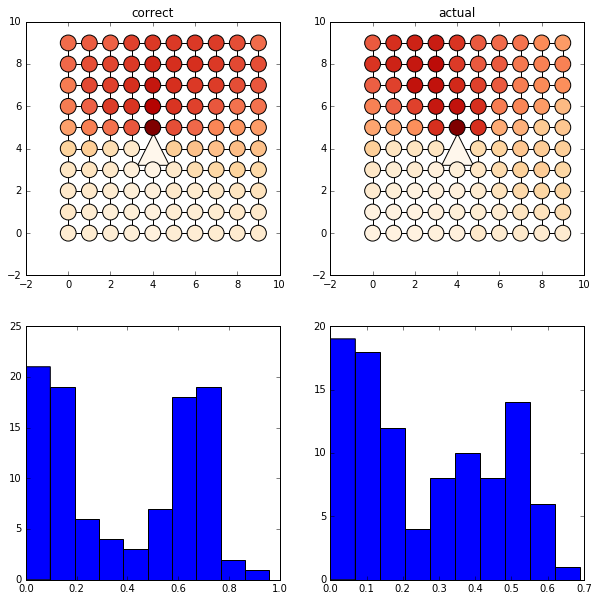

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
reward = reward_by_infection_direction(g, q, u)
plot_snapshot(g, pos, reward, query_node=q, ax=ax[0, 0])
ax[1, 0].hist(list(reward.values()))
ax[0, 0].set_title('correct')

reward = {n: tbl1[(n, u, q)] for n in g.nodes_iter()}
plot_snapshot(g, pos, reward, query_node=q, ax=ax[0, 1])
ax[1, 1].hist(list(reward.values()))
ax[0, 1].set_title('actual')

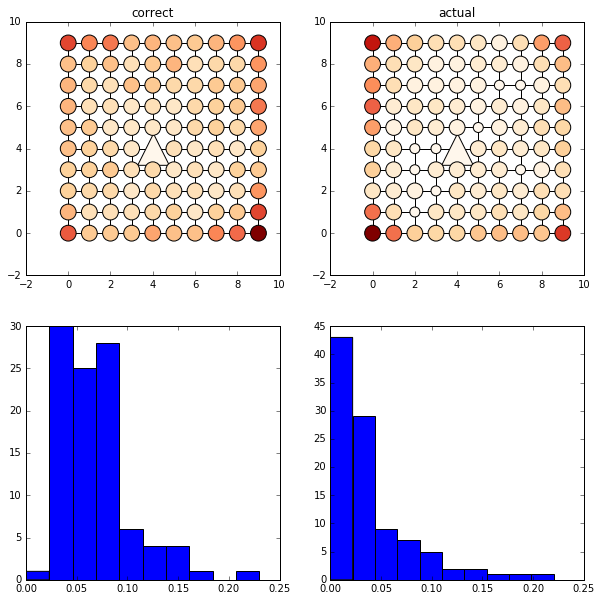

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
reward = reward_by_uninfected_node(g, q)
plot_snapshot(g, pos, reward, query_node=q, ax=ax[0, 0])
ax[1, 0].hist(list(reward.values()))
ax[0, 0].set_title('correct')

reward = {n: tbl2[(n, q)] for n in g.nodes_iter()}
plot_snapshot(g, pos, reward, query_node=q, ax=ax[0, 1])
ax[1, 1].hist(list(reward.values()))
ax[0, 1].set_title('actual')

In [53]:
def median_node(g, mu, sp_len):
    def sum_of_weighted_dist(q):
        mus = np.array([mu[v] for v in g.nodes_iter()])
        lens = np.array([sp_len[q][v] for v in g.nodes_iter()])
        return np.sum(mus * lens)

    return min(g.nodes_iter(), key=sum_of_weighted_dist)

In [58]:
def mwu_by_infection_direction(g, obs_nodes, infection_times, source,
                               direction_reward_table=None,
                               inf_reward_table=None,
                               save_logs=False,
                               debug=False):
    mu = {n: 1 for n in g.nodes_iter()}
    sp_len = nx.shortest_path_length(g, weight='d')
    centroids = []
    queried_nodes = set(obs_nodes)
    while True:
        if len(queried_nodes) == g.number_of_nodes():
            print("no more queries to go")
            break
        q = median_node(g, mu, sp_len)
        queried_nodes.add(q)
        
        if debug:
            print('query node: {}'.format(q))
        
        if save_logs:
            centroids.append(q)
        found_source = True
        if np.isinf(infection_times[q]):
            found_source = False
            if inf_reward_table:
                reward = {n: inf_reward_table[(n, q)] for n in g.nodes_iter()}
            else:
                reward = reward_by_uninfected_node(g, q)
        else:
            for u in g.neighbors(q):
                if infection_times[u] < infection_times[q]:
                    queried_nodes.add(u)
                    if direction_reward_table:
                        reward = {n: direction_reward_table[(n, u, q)] for n in g.nodes_iter()}
                    else:
                        reward = reward_by_infection_direction(g, q, u)                    
                    found_source = False
                    break
        if found_source:
            assert source == q
            break
            
        for n in g.nodes_iter():
            mu[n] *= reward[n]
        mu = normalize_mu(mu)
    return len(queried_nodes - obs_nodes)

In [59]:
def experiment_mwu_multiple_rounds(g, fraction=0.05,
                                   sampling_method='late_nodes',
                                   rounds=100):
    counts = []
    dir_tbl, inf_tbl = build_reward_table(g)
    for i in tqdm(range(rounds)):
        source, obs_nodes, infection_times, tree = make_partial_cascade(
            g, fraction, sampling_method=sampling_method)
        query_count = mwu_by_infection_direction(
            g, obs_nodes, infection_times, source,
            direction_reward_table=dir_tbl,
            inf_reward_table=inf_tbl,
            save_logs=False)
        counts.append(query_count)
    return counts

In [62]:
counts = experiment_mwu_multiple_rounds(g)

100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


In [63]:
from experiment_utils import counts_to_stat
counts_to_stat(counts)

{'25%': 6.0,
 '50%': 8.0,
 '75%': 10.0,
 'count': 100.0,
 'max': 70.0,
 'mean': 8.9299999999999997,
 'min': 1.0,
 'std': 7.1098949401946907}